# Face Recognition

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" For example, the video lecture showed a [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

## Librarys

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.image import resize

from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model

from numpy import genfromtxt
import tensorflow as tf
import PIL

# from utils.inception_network import faceRecoModel
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3

# from utils.facenet_utils.get_data import root_folder, download_folder, selection_folder, download_path

import numpy as np
import os
import sys
import random
import tensorflow as tf
from pathlib import Path
from six.moves import urllib
import tarfile
import shutil

K.set_image_data_format('channels_last')
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Naive Face Verification

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images is below a chosen threshold, it may be the same person!

<center><img src="images/pixel_comparison.png" style="width:380px;height:150px;"></center>
<caption><center> <u><b>Figure 1</b> </u></center></caption>

Of course, this algorithm performs poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, minor changes in head position, and so on.

You'll see that rather than using the raw image, you can learn an encoding, $f(img)$.

By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

## Encoding Face Images into a 128-Dimensional Vector

### Using a ConvNet to Compute Encodings

The FaceNet model takes a lot of data and a long time to train. So following the common practice in applied deep learning, we'll load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842) An Inception network implementation has been provided in the file `inception_blocks_v2.py`.  

The key things to be aware of are:

- This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$
- The input images are originally of shape 96x96, thus, you need to scale them to 160x160. This is done in the `img_to_encoding()` function.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

In [2]:
K.set_image_data_format('channels_last')
target_size = (160, 160)

inception_model = InceptionV3(weights='imagenet', input_shape = target_size + (3, ), include_top=False)

In [3]:
print(inception_model.inputs)
print(inception_model.outputs)

[<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=None, name=keras_tensor>]
[<KerasTensor shape=(None, 3, 3, 2048), dtype=float32, sparse=False, name=keras_tensor_310>]


In [4]:
inception_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 79, 79,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 79, 79,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 79, 79,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 77, 77,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 77, 77,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 77, 77,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 77, 77,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 77, 77,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 77, 77,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 38, 38,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 36, 36,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 36, 36,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [5]:
flat_layer = layers.Flatten()(inception_model.output)
dense_layer_1 = layers.Dense(512, activation='relu')(flat_layer)
dense_layer_1 = layers.BatchNormalization()(dense_layer_1)
dense_layer_2 = layers.Dense(512, activation='relu')(dense_layer_1)
dense_layer_2 = layers.BatchNormalization()(dense_layer_2)
# dense_layer_3 = layers.Dense(2, activation='relu')(dense_layer_2)

# next I specify which layers to 'freeze' and which layers to keep training
# freeze all convolutional InceptionV3 layers 
# and train only the layers I added at the top (initialized with random values)
# for layer in inception_model.layers:
#     layer.trainable = False

#define a model with the layers we've just connected
transfer_inception_model = Model(inputs = inception_model.inputs, outputs = dense_layer_2)

In [6]:
print(transfer_inception_model.inputs)
print(transfer_inception_model.outputs)

[<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=None, name=keras_tensor>]
[<KerasTensor shape=(None, 512), dtype=float32, sparse=False, name=keras_tensor_315>]


In [7]:
FRmodel = transfer_inception_model

## Applying the Model

You're building a system for an office building where the building manager would like to offer facial recognition to allow the employees to enter the building.

You'd like to build a face verification system that gives access to a list of people. To be admitted, each person has to swipe an identification card at the entrance. The face recognition system then verifies that they are who they claim to be.

### Face Verification

Now we'll build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding, we'll use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image.

Run the following code to build the database (represented as a Python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.

In [8]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [9]:
database = {}
path_test = '../datasets/faces/test/'
database["danielle"] = img_to_encoding(path_test + "danielle.png", FRmodel)
database["younes"] = img_to_encoding(path_test + "younes.jpg", FRmodel)
database["tian"] = img_to_encoding(path_test + "tian.jpg", FRmodel)
database["andrew"] = img_to_encoding(path_test + "andrew.jpg", FRmodel)
database["kian"] = img_to_encoding(path_test + "kian.jpg", FRmodel)
database["dan"] = img_to_encoding(path_test + "dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding(path_test + "sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding(path_test + "bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding(path_test + "kevin.jpg", FRmodel)
database["felix"] = img_to_encoding(path_test + "felix.jpg", FRmodel)
database["benoit"] = img_to_encoding(path_test + "benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding(path_test + "arnaud.jpg", FRmodel)

By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. Then we can use the encodings to compare two face images as follows:

<center><img src="images/distance_kiank.png\" style="width:680px;height:250px;"></center>
<caption><center> <u>  <b>Figure 2:</b> <br> </u> By computing the distance between two encodings and thresholding, you can determine if the two pictures represent the same person</center></caption>

So, an encoding is a good one if:

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.
    
<center><img src="images/triplet_comparison.png" style="width:280px;height:150px;"><br></center>
<caption><center> <u> <b>Figure 3: </b> <br> </u> In the next section,  you'll call the pictures from left to right: Anchor (A), Positive (P), Negative (N)</center></caption>

In [10]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = tf.norm(database[identity] - encoding)
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
         
    return dist, door_open

In [11]:
danielle = tf.keras.preprocessing.image.load_img(path_test + "danielle.png", target_size=(160, 160))
kian = tf.keras.preprocessing.image.load_img(path_test + "kian.jpg", target_size=(160, 160))

In [12]:
np.around(np.array(kian) / 255.0, decimals=12).shape

(160, 160, 3)

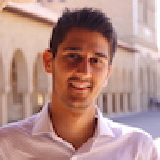

In [13]:
kian

In [14]:
np.around(np.array(danielle) / 255.0, decimals=12).shape

(160, 160, 3)

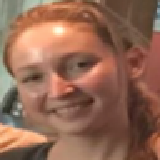

In [15]:
danielle

In [16]:
verify(path_test  + "camera_2.jpg", "danielle", database,  FRmodel)

It's not danielle, please go away


(<tf.Tensor: shape=(), dtype=float32, numpy=0.8360488>, False)

In [17]:
verify(path_test  + "camera_0.jpg", "younes", database, FRmodel)

It's younes, welcome in!


(<tf.Tensor: shape=(), dtype=float32, numpy=0.43944496>, True)

## Siamese

### Triplet loss

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.

<a name='3-2'></a>
### 3.2 - The Triplet Loss

For an image $x$, its encoding is denoted as $f(x)$, where $f$ is the function computed by the neural network.

<img src="images/f_x.png" style="width:380px;height:150px;">

Training will use triplets of images $(A, P, N)$:

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from the training dataset. $(A^{(i)}, P^{(i)}, N^{(i)})$ is used here to denote the $i$-th training example.

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$
|| f\left(A^{(i)}\right)-f\left(P^{(i)}\right)||_{2}^{2}+\alpha<|| f\left(A^{(i)}\right)-f\left(N^{(i)}\right)||_{2}^{2}
$$


You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$
Here, the notation "$[z]_+$" is used to denote $max(z,0)$.

**Notes**:

- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small.
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
- $\alpha$ is called the margin. It's a hyperparameter that you pick manually. You'll use $\alpha = 0.2$.

Most implementations also rescale the encoding vectors to haven L2 norm equal to one (i.e., $\mid \mid f(img)\mid \mid_2$=1); you won't have to worry about that in this assignment.

<a name='ex-1'></a>
### Exercise 1 - triplet_loss

Implement the triplet loss as defined by formula (3). These are the 4 steps:

1. Compute the distance between the encodings of "anchor" and "positive": $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of "anchor" and "negative": $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
4. Compute the full formula by taking the max with zero and summing over the training examples:$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$

*Hints*:

- Useful functions: `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, `tf.maximum()`.

- For steps 1 and 2, sum over the entries of $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$ and $\mid \mid     f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$.

- For step 4, you will sum over the training examples.

*Additional Hints*:

- Recall that the square of the L2 norm is the sum of the squared differences: $||x - y||_{2}^{2} = \sum_{i=1}^{N}(x_{i} - y_{i})^{2}$

- Note that the anchor, positive and negative encodings are of shape (*m*,128), where *m* is the number of training examples and 128 is the number of elements used to encode a single example.

- For steps 1 and 2, maintain the number of *m* training examples and sum along the 128 values of each encoding. `tf.reduce_sum` has an axis parameter. This chooses along which axis the sums are applied.

- Note that one way to choose the last axis in a tensor is to use negative indexing (axis=-1).

- In step 4, when summing over training examples, the result will be a single scalar value.

- For `tf.reduce_sum` to sum across all axes, keep the default value axis=None.

In [18]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    #(≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

# Facial Recognition

## Similarity Function
The alternative to learning what each class looks like is to learn a similarity function, a function of the degree of difference between images.

The output of such a function would be something like:
d(picture_1, picture_2) = the degree of difference between two pictures.

Afterwards, the facial recognition function would compare the degree of difference between the new input image and an image from our database.
If d < thereshold => it's the same person.

### Siamese Network
To compute the degree of difference, we could compare pixel by pixel. But this would not give the best results when we deal with different pose, different illumination etc for the same person.

A better alternative is called a Siamese Network ([Taigman et al 2014](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf)). This method uses two identical CNNs that compute embeddings - vector encodings of the input image. And aftwrwards it compares the distance between these embeddings.

#### The triplet function
So we're trying to train a neural network, to learn parameters (weights and biases for each layer) so that:

* when two different images of the same person are presented -> d(output1, output2) is small
* when two images of different persons are presented -> d(output1, output3) is large

So our final network will look like the one in Figure 7.*

The image we need to make a judgement on is called anchor.
We compare it to an image of the person we're trying tp verify it against (positive image).
And we compare it against a picture of a person who is not the same as in the anchor image (negative image).

In [19]:
target_size = (224, 224)

inception_model = InceptionV3(weights='imagenet', input_shape = target_size + (3,), include_top=False)

flat_layer = layers.Flatten()(inception_model.output)
dense_layer_1 = layers.Dense(512, activation='relu')(flat_layer)
dense_layer_1 = layers.BatchNormalization()(dense_layer_1)
dense_layer_2 = layers.Dense(256, activation='relu')(dense_layer_1)
dense_layer_2 = layers.BatchNormalization()(dense_layer_2)
dense_layer_3 = layers.Dense(256, activation='relu')(dense_layer_2)

# next I specify which layers to 'freeze' and which layers to keep training
# freeze all convolutional InceptionV3 layers 
# and train only the layers I added at the top (initialized with random values)
for layer in inception_model.layers:
    layer.trainable = False

#define a model with the layers we've just connected
transfer_inception_model = Model(inputs = inception_model.inputs, outputs = dense_layer_3)

In [20]:
class SimilarityLayer(layers.Layer):
    # compute and return the two distances:
    # d(anchor,positive) 
    # d(anchor,negative)
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, inputs):
        anchor, positive, negative = inputs
        pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
        return pos_dist, neg_dist
    
# Define the inputs
anchor = layers.Input(name='anchor', shape = target_size + (3,))
positive = layers.Input(name='positive', shape = target_size + (3,))
negative = layers.Input(name='negative', shape = target_size + (3,))

# Process the inputs through the InceptionV3 model and get embeddings
anchor_embedding = transfer_inception_model(inception_v3.preprocess_input(anchor))
positive_embedding = transfer_inception_model(inception_v3.preprocess_input(positive))
negative_embedding = transfer_inception_model(inception_v3.preprocess_input(negative))

# Compute the similarity layer output
sim_layer_output = SimilarityLayer()([anchor_embedding, positive_embedding, negative_embedding])


# Construct the Siamese model
siamese_model = Model(inputs=[anchor, positive, negative], outputs=sim_layer_output)

siamese_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ anchor[0][0]      │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_1       │ (None, 224, 224,  │          0 │ positive[0][0]    │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_2       │ (None, 224, 224,  │          0 │ negative[0][0]    │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 224, 224,  │          0 │ true_divide_1[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 224, 224,  │          0 │ true_divide_2[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 256)       │ 48,217,888 │ subtract[0][0],   │
│ (Functional)        │                   │            │ subtract_1[0][0], │
│                     │                   │            │ subtract_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_layer    │ [(None), (None)]  │          0 │ functional_3[0][… │
│ (SimilarityLayer)   │                   │            │ functional_3[1][… │
│                     │                   │            │ functional_3[2][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,217,888 (183.94 MB)

 Trainable params: 26,413,568 (100.76 MB)

 Non-trainable params: 21,804,320 (83.18 MB)

Wrap a custom Model class aroung the siamese_model above so that we can implement a custom training loop that optimizes the difference between distances.

For the class definition below I used Keras' official documentation for writing your own training loop.

In [21]:
class SiameseModelClass(Model):
    def __init__(self, siamese_model, margin = 0.5):
        super(SiameseModelClass, self).__init__()
        
        self.siamese_model = siamese_model
        self.margin = margin
        
        # create a Metric instance to track the loss
        self.loss_tracker = metrics.Mean(name="loss")
        
    def call(self, inputs):
        return self.siamese_model(inputs)
    
    # customize the training process: providing our own training step
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # call custom loss function
            loss = self.custom_loss(data)
            
        # Compute gradients
        trainable_vars = self.siamese_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update our training loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    # providing our own evaluation step
    def test_step(self, data):
        # call custom loss function
        loss = self.custom_loss(data)
        
        # Update our test loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    # custom loss function
    def custom_loss(self, data):
        # get the distances tuple from the siamese model output
        d1, d2 = self.siamese_model(data)
        
        # compute the triplet loss
        loss = tf.maximum(d1 - d2 + self.margin, 0)
        
        return loss
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker]

## Training

### Faces dataset

In [22]:
root_folder = '../datasets/faces'
download_folder = root_folder + '/'+ 'lfw_original'
selection_folder = root_folder + '/' + 'lfw_selection'
download_path = download_folder + '/lfw-deepfunneled.tgz'

In [23]:
extracted_folder = download_folder + '/lfw-deepfunneled'

# images are organized into separate folders for each person
# get a list of subfolders 
subfolders = [x[0] for x in os.walk(extracted_folder)]

In [24]:
people_list = []

for path in subfolders:
    image_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    people_list.append((path.split('\\')[-1], image_count))
    #people_count.append((path, image_count))
    
# Sort from max to min images per person
people_list = sorted(people_list, key=lambda x: x[1], reverse=True)

In [25]:
print(f'Number of people: {len(subfolders)}')
print(f'Number of people with only one photo: {len([person for person, image_count in people_list if image_count==1])}')
print(f'Number of people with >=5 photos: {len([person for person, image_count in people_list if image_count>=5])}')

Number of people: 5750
Number of people with only one photo: 4069
Number of people with >=5 photos: 423


How many exemplars per class do we need ?

For this problem, each training example will consist of a triplet of images: the anchor, the positive and the negative image. The anchor and the positive image are two different pictures from the same class. If one class has n exemplars, we can make this amount of anchor, positive pairs:

$$
C(n, k) = \binom{n}{k} = \frac{n!}{k!(n-k)!} = \frac{n(n-1)}{k}
$$

where k is 2 in our case.

So, if we have 5 different images for a class, we will be able to compose $5! / ((5-2)!*2!) = 10$ anchor-positive pairs.

Then, to complete our triplet, we will select one random image from any other class expect the one we got the anchor from.

In [26]:
images = []
i = 0
selected_persons = {}

for root, dirnames, filenames in os.walk(selection_folder):
    file_list = []
    if filenames:  # Ensure there are filenames to process
        for file in filenames:
            filename = os.path.basename(file)
            file_list.append(os.path.join(root, filename))

            images.append(os.path.join(root, filename))
        
        selected_persons[i] = file_list
        i = i + 1

selected_persons[0]

['../datasets/faces/lfw_selection\\Abdullah_Gul\\Abdullah_Gul_0001.jpg',
 '../datasets/faces/lfw_selection\\Abdullah_Gul\\Abdullah_Gul_0002.jpg',
 '../datasets/faces/lfw_selection\\Abdullah_Gul\\Abdullah_Gul_0003.jpg',
 '../datasets/faces/lfw_selection\\Abdullah_Gul\\Abdullah_Gul_0004.jpg',
 '../datasets/faces/lfw_selection\\Abdullah_Gul\\Abdullah_Gul_0005.jpg']

Generate the list of (anchor, positive, negative) triplets for our training and testing.

For anchor and positive we generate all combinations of two from the 5 available images per person.

For the negative, we choose a random class and a random image rank (of the 5 images we have per class).

In [27]:
triplets = []

for item in selected_persons.items():
    images = item[1]

    for i in range(len(images)-1):
        for j in range(i+1,len(images)):

            anchor = images[i]
            positive = images[j]
            
            # choose a random negative
            # first generate a random class rank and make sure we're not selecting the current class
            random_class = item[0]
            while random_class == item[0]:
                random_class = random.randint(0, len(selected_persons)-1)
            # selected a random image from the 5 that any of our classes has
            random_image = random.randint(0, 4)
            negative = selected_persons[random_class][random_image]
            
            triplets.append((anchor, positive, negative))

Visualize a few of our triplets.

In [28]:
# Helper function for needed preprocessing of our jpg images
def preprocess_image(filename, target_size):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    return image

In [31]:
def plot_images(triplets, target_size):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    fig = plt.figure(figsize=(7, 12))
    axis = fig.subplots(5, 3)
    
    for i in range(0, 5):
        anchor, positive, negative = triplets[40 + i]
        show(axis[i, 0], preprocess_image(anchor, target_size))
        show(axis[i, 1], preprocess_image(positive, target_size))
        show(axis[i, 2], preprocess_image(negative, target_size))

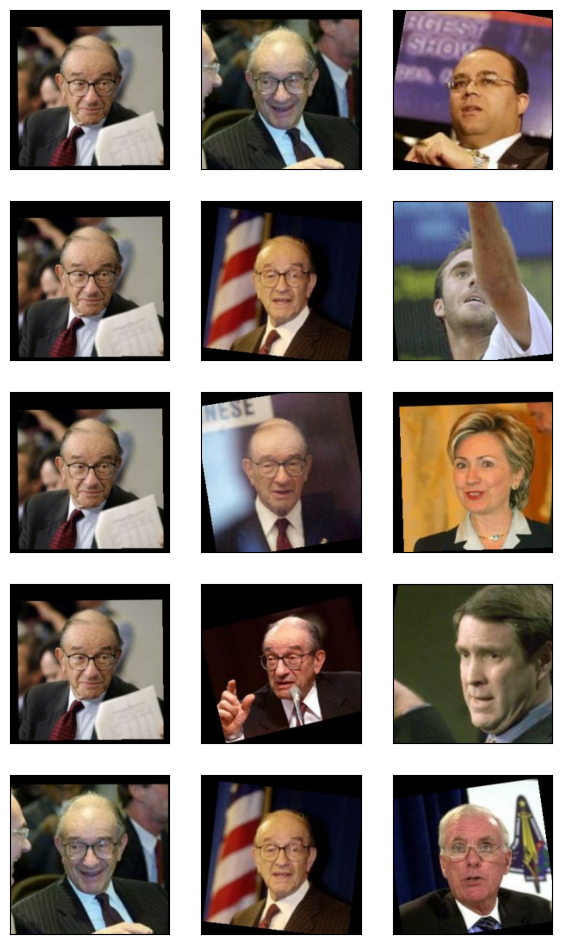

In [32]:
plot_images(triplets, target_size)

In [ ]:
# use the GPU training instead

model_on_GPU = SiameseModelClass(siamese_model)
model_on_GPU.compile(optimizer = optimizers.Adam(0.0001))
#model_on_GPU.fit(training_data, epochs=epochs, validation_data = validation_data)

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

In [ ]:
import time
start = time.time()

epochs = 15
with tf.device('/gpu:0'):
    history = model_on_GPU.fit(
        training_data, 
        epochs=epochs, 
        validation_data = validation_data
    )
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')